In [1]:
# This notebook take UVES images numpy arrays and compute the resnet50 descriptors
# After that it save the descriptors in the descriptor blob in azure
from azure.storage.blob import BlockBlobService, PublicAccess
import sys
sys.path.append('./')

In [4]:
# Create the BlockBlockService that is used to call the Blob service 
# for the storage account
import config_blob_keys as cfg

account_name = cfg.AccountName
account_key = cfg.AccountKey
block_blob_service = BlockBlobService(account_name=account_name, account_key=account_key)

cont_name_analysis = cfg.ContNameAnalysis
block_blob_service.set_container_acl(cont_name_analysis, public_access=PublicAccess.Container)

cont_name_desc = cfg.ContNameDesc
block_blob_service.set_container_acl(cont_name_desc, public_access=PublicAccess.Container)

cont_name_desc_cor = cfg.ContNameDescCor
block_blob_service.set_container_acl(cont_name_desc_cor, public_access=PublicAccess.Container)

In [4]:
# Create a list "filelist" with the blob content
# inside the "Azure:container/folder" location 
def BlobList(container, folder, filelist, verbose=False):
    
    gen = block_blob_service.list_blobs(container, prefix=folder)
    
    for blob in gen:
        file = str(blob.name).replace(folder,'')
        filelist.append(file)
        if verbose == True:
            print("\t Blob name: " + blob.name)
        
    return filelist

# Download a file "blobfile" from "container" and save it 
# in the file "locfile"
def DownBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    
    block_blob_service.get_blob_to_path(container, blobfile, locfile)

    if verbose == True:
        print('Downloading ' + blobfile + ' to ' + locfile)
    

# Uncompress data 
def UnCompress(file, verbose=False):
    
    if verbose == True:
        print('Uncompressing ' + file)
    
    subprocess.call(['uncompress', file])
    #os.popen('uncompress ' + file)

# Upload file "locfile" to the blob "blobfile" in container
def UpBlob(container, blobfile, locfile, verbose=False):
    
    if verbose == True:
        print('Uploading ' + locfile + ' to ' + blobfile)
        
    block_blob_service.create_blob_from_path(container, blobfile, locfile, validate_content=True)


In [5]:
import pandas as pd
import numpy as np
import utils_blob as ub
import os
import multiprocessing
import tqdm
import time
import random

from functools import partial

ModuleNotFoundError: No module named 'utils_blob'

In [1]:
npool = 4
nsample = 10
check_from_list = False
method_dir = 'numpy/method2'
random.seed(100)

# Define the subdirs to be created in /descriptor based on the image type and ext
#npyBlobSubDirs = ['UVES_BLUE_BIAS','UVES_RED_BIAS','UVES_BLUE_WAVE','UVES_DIC1B_FLAT','UVES_DIC1B_DFLAT','UVES_RED_WAVE','UVES_DIC1R_FLAT']
#npyBlobSubDirs = ['UVES_BLUE_WAVE','UVES_DIC1B_FLAT','UVES_DIC1B_DFLAT','UVES_RED_WAVE','UVES_DIC1R_FLAT']
# Test
DescBlobSubDirs = ['UVES_DIC1B_DFLAT']

path_loc = '../Temp/test'

# Loof for images type folder
for desc_blob_sub_dir in DescBlobSubDirs:
    # Images extensions
    
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        Exten = [0]
    elif desc_blob_sub_dir == 'UVES_RED_BIAS' or desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        Exten = [1]#,2]
    
    # Define the image type
    if desc_blob_sub_dir == 'UVES_BLUE_BIAS':
        image_type = 'bias_blue'
    elif desc_blob_sub_dir == 'UVES_RED_BIAS':
        image_type = 'bias_red'
    elif desc_blob_sub_dir == 'UVES_BLUE_WAVE' or desc_blob_sub_dir == 'UVES_DIC1B_FLAT' or desc_blob_sub_dir == 'UVES_DIC1B_DFLAT':
        image_type = 'blue_arc_flat'
    elif desc_blob_sub_dir == 'UVES_RED_WAVE' or desc_blob_sub_dir == 'UVES_DIC1R_FLAT':
        image_type = 'red_arc_flat'

    # Take bad images
    PROJECT_DIR = "/data/notebooks/uves_jprieto"
    DATA_DIR = os.path.join(PROJECT_DIR, "data")
    
    uves_flag_file=os.path.join(DATA_DIR, 'UVES_hidden_flag_results.txt')
    uves_flag_df=pd.read_csv(uves_flag_file, comment='#', sep=';')
    #uves_flag_df['filename'] = uves_flag_df['filename']+'.fits'
    corrupted_df = uves_flag_df[(uves_flag_df['image_type'] == image_type) & (uves_flag_df['flag'] == 'CORRUPTED')]
    bad_files_garchim = list(corrupted_df['filename']) 
    
    # Loop for images extensions
    for ext in Exten:
        extension = 'ext'+str(ext)
        print('Working on ' + desc_blob_sub_dir + ' extension ' + extension + '...\n')
        
        # Bad Garchim images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        desc_cor_list = []
        desc_files_list = [s for s in desc_files_list if any(xs in s for xs in bad_files_garchim)]
        
        if len(desc_files_list) >= nsample:
            desc_files_list = random.sample(desc_files_list, nsample)
        desc_badg_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        print('Bad Garchim images...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)

                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_badg = np.delete(desc_matrix,0,axis=0)        

        # Good images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc, desc_folder_rem, desc_files_list)
        
        #print(len(desc_files_list))
        #desc_files_list = [s for s in desc_files_list if any(xs not in s for xs in bad_files_garchim)]
        #print(len(desc_files_list))
        descriptor_file = [s for s in descriptor_file if s not in bad_files_garchim]
        desc_files_list = random.sample(desc_files_list, nsample)
        desc_good_files = desc_files_list
        
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        print('Good images...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file

                DownBlob(cont_name_desc, desc_blob_name, descriptor_file, False)
                
                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)

                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_good = np.delete(desc_matrix,0,axis=0)
        
        # Bad Nicolas images
        # ----------------------------------------------------------------------
        desc_folder_rem = os.path.join(method_dir,desc_blob_sub_dir)
        desc_folder_rem = os.path.join(desc_folder_rem,extension)
        
        desc_files_list = []
        BlobList(cont_name_desc_cor, desc_folder_rem, desc_files_list)
        if nsample<=100:
            desc_files_list = random.sample(desc_files_list, nsample)
        desc_badn_files = desc_files_list
        desc_temp = np.zeros(2048).T
        desc_matrix = np.expand_dims(desc_temp,axis=0)

        print('Bad Nicolas images...')
        with tqdm.tqdm_notebook(total=len(desc_files_list)) as pbar:
            for idx in range(len(desc_files_list)):
                
                file = desc_files_list[idx]
                desc_blob_name = desc_folder_rem + file
                descriptor_file = path_loc + file
                
                DownBlob(cont_name_desc_cor, desc_blob_name, descriptor_file, False)

                while not os.path.exists(descriptor_file):
                    time.sleep(0.1)
                    
                desc_resNet50 = np.load(descriptor_file)
                np_desc = np.array(desc_resNet50)
                desc_matrix = np.vstack((desc_matrix,np_desc))
                os.remove(descriptor_file)
                pbar.update(1)
        
        desc_badn = np.delete(desc_matrix,0,axis=0)

NameError: name 'random' is not defined

In [503]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

desc_good = normalize(desc_good)
desc_badn = normalize(desc_badn) 
desc_badg = normalize(desc_badg) 

desc_mat = np.vstack((desc_good,desc_badn,desc_badg))

A_spr      = sparse.csr_matrix(desc_mat)
A_good_spr = sparse.csr_matrix(desc_good)
A_badn_spr = sparse.csr_matrix(desc_badn)
A_badg_spr = sparse.csr_matrix(desc_badg)

sim      = cosine_similarity(A_spr)
sim_good = cosine_similarity(A_good_spr)
sim_badn = cosine_similarity(A_badn_spr)
sim_badg = cosine_similarity(A_badg_spr)

sim_spr      = cosine_similarity(A_spr,dense_output=False)
sim_good_spr = cosine_similarity(A_good_spr,dense_output=False)
sim_badn_spr = cosine_similarity(A_badn_spr,dense_output=False)
sim_badg_spr = cosine_similarity(A_badg_spr,dense_output=False)

In [504]:
import matplotlib.pyplot as plt

[[0.99999972]]


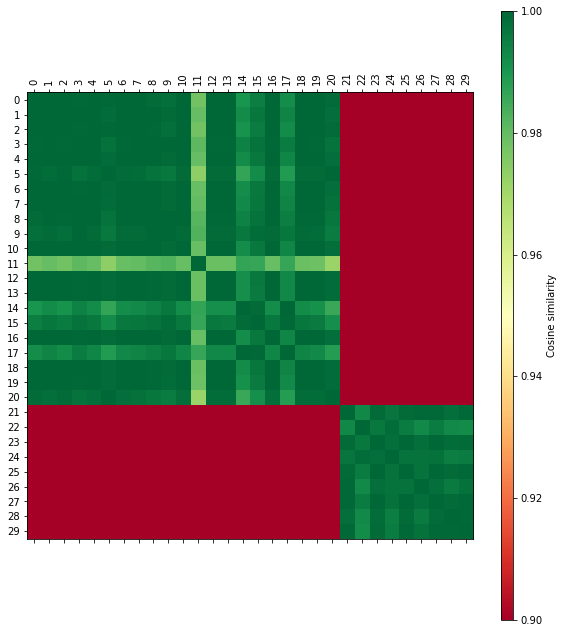

In [505]:
# Plot the correlation matrix
size = 12

df_desc = pd.DataFrame(desc_mat)
df_sim = pd.DataFrame(sim)
mat = sim

fig, ax = plt.subplots(figsize=(10, 14))
cax = ax.matshow(df_sim, cmap='RdYlGn', vmin=0.9)
plt.xticks(range(len(df_sim.columns)), df_sim.columns, rotation=90);
plt.yticks(range(len(df_sim.columns)), df_sim.columns);
cbar = fig.colorbar(cax, aspect=50, shrink=.8)
#cbar.set_clim(0.5,1.0)
cbar.set_label('Cosine similarity', rotation=90)
fig.show()
fig.savefig('CosineSimilarity.png')

vec1 = mat[1,:]
vec2 = mat[2,:]
cos_dist = cosine_similarity([vec1],[vec2])
print(cos_dist)

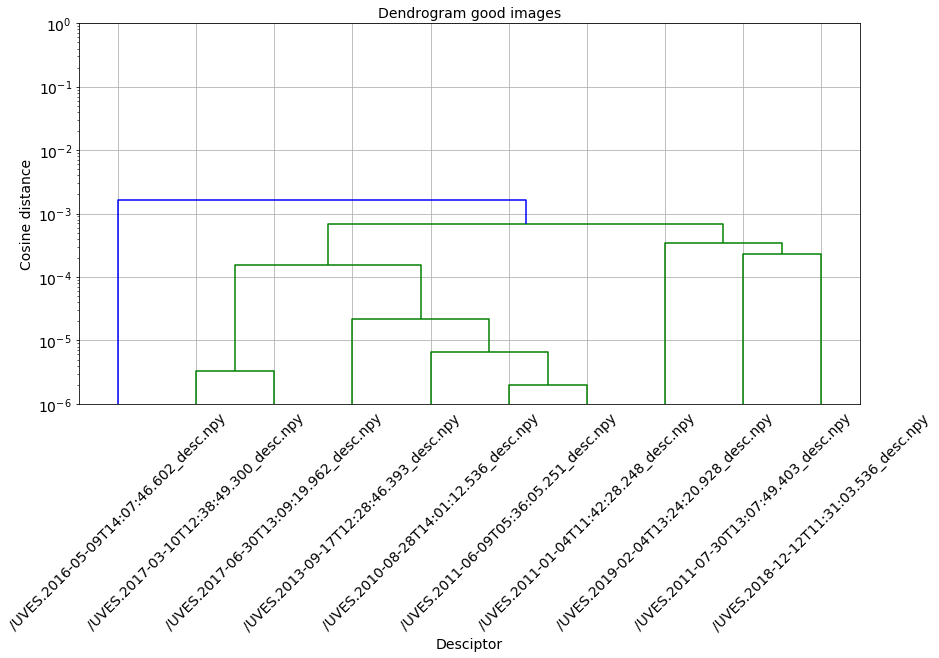

In [506]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(14, 7))  
plt.title("Dendrogram good images", fontsize=14)  
dend = sch.dendrogram(sch.linkage(desc_good, method='average', metric='cosine'), labels=desc_good_files, leaf_rotation=45)
plt.xlabel('Desciptor', fontsize=14)
plt.ylabel('Cosine distance', fontsize=14)
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim((0.000001,1))
plt.grid()
plt.savefig('DendrogramGood.png')

In [507]:
print(dend)

{'icoord': [[15.0, 15.0, 25.0, 25.0], [55.0, 55.0, 65.0, 65.0], [45.0, 45.0, 60.0, 60.0], [35.0, 35.0, 52.5, 52.5], [20.0, 20.0, 43.75, 43.75], [85.0, 85.0, 95.0, 95.0], [75.0, 75.0, 90.0, 90.0], [31.875, 31.875, 82.5, 82.5], [5.0, 5.0, 57.1875, 57.1875]], 'dcoord': [[0.0, 3.317271043634662e-06, 3.317271043634662e-06, 0.0], [0.0, 1.958772599119918e-06, 1.958772599119918e-06, 0.0], [0.0, 6.68536847570067e-06, 6.68536847570067e-06, 1.958772599119918e-06], [0.0, 2.1688095082147047e-05, 2.1688095082147047e-05, 6.68536847570067e-06], [3.317271043634662e-06, 0.00015687503371308864, 0.00015687503371308864, 2.1688095082147047e-05], [0.0, 0.00022979899208408483, 0.00022979899208408483, 0.0], [0.0, 0.00034476152897444656, 0.00034476152897444656, 0.00022979899208408483], [0.00015687503371308864, 0.0006828113179680154, 0.0006828113179680154, 0.00034476152897444656], [0.0, 0.0016580818355005726, 0.0016580818355005726, 0.0006828113179680154]], 'ivl': ['/UVES.2016-05-09T14:07:46.602_desc.npy', '/UVES

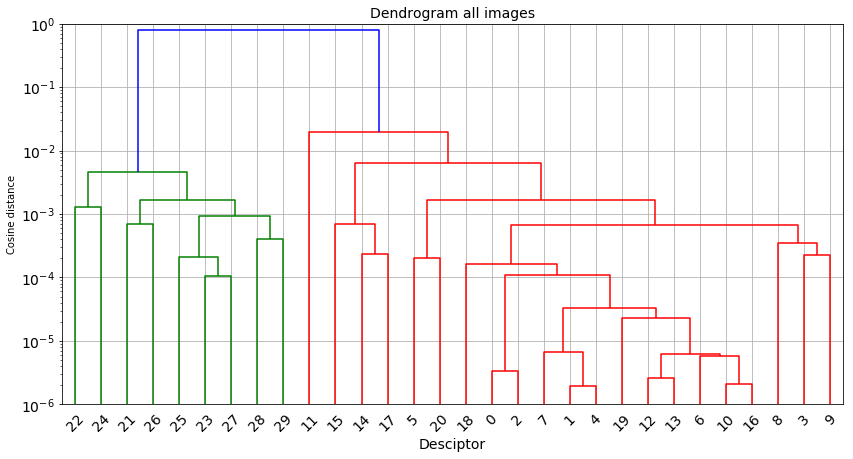

In [508]:
plt.figure(figsize=(14, 7))  
plt.title("Dendrogram all images", fontsize=14)  
dend = sch.dendrogram(sch.linkage(desc_mat, method='average', metric='cosine'))
plt.xlabel('Desciptor', fontsize=14)
plt.ylabel('Cosine distance')
plt.yscale('log')
plt.xticks(fontsize=14)#, rotation=45)
plt.yticks(fontsize=14)
plt.ylim((0.000001,1))
plt.grid()
plt.savefig('DendrogramAll.png')

In [509]:
from scipy.cluster.hierarchy import single, fcluster, average
from scipy.spatial.distance import pdist

Bad Nicolas:  /UVES.2012-09-07T10:40:51.229C754_desc.npy
Bad Garchim:  /UVES.2017-02-02T02:37:00.586_desc.npy
(12, 2048)
[[1.28706760e-05 6.00164812e-05 1.42898223e-06 ... 7.16117756e-07
  5.64011150e-06 3.87330399e-02]
 [9.96205174e-06 5.48213269e-05 2.55644145e-06 ... 4.34104648e-06
  1.71546853e-05 3.94299154e-02]
 [1.08885433e-05 5.81911876e-05 1.44162377e-06 ... 4.44895211e-07
  7.44631019e-06 3.89077471e-02]
 ...
 [1.60995665e-05 6.27225186e-05 2.32815885e-06 ... 2.42964052e-06
  1.25104062e-04 4.20816805e-02]
 [6.84059535e-06 6.07225170e-05 1.61198130e-06 ... 0.00000000e+00
  1.35343069e-05 3.92066511e-02]
 [2.27553401e-03 1.01223594e-03 5.61879433e-03 ... 6.87647727e-02
  5.06829670e-04 0.00000000e+00]]
(66,)
[1.78032667e-04 3.31727104e-06 7.78661095e-04 1.79910842e-04
 5.22497482e-04 1.01489058e-04 2.36449010e-04 8.00819071e-04
 1.70467235e-03 1.16663497e-04 7.92963181e-01 1.40633589e-04
 3.10384013e-04 1.95877260e-06 1.28251902e-03 1.76538397e-05
 8.61517803e-06 2.39394449e-0

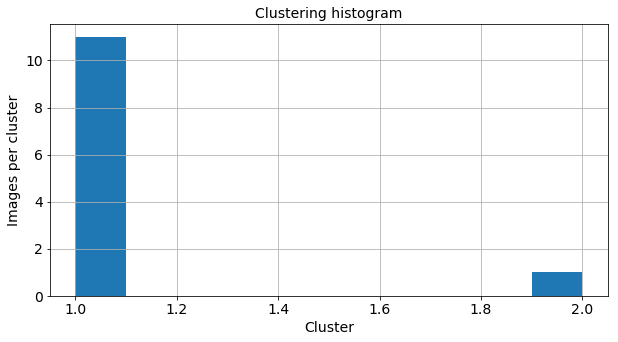

[[1.00000000e+00 4.00000000e+00 1.95877260e-06 2.00000000e+00]
 [0.00000000e+00 2.00000000e+00 3.31727104e-06 2.00000000e+00]
 [7.00000000e+00 1.20000000e+01 4.75555892e-06 3.00000000e+00]
 [1.00000000e+01 1.40000000e+01 7.75296890e-06 4.00000000e+00]
 [6.00000000e+00 1.50000000e+01 8.80633016e-06 5.00000000e+00]
 [1.30000000e+01 1.60000000e+01 7.74629002e-05 7.00000000e+00]
 [8.00000000e+00 1.70000000e+01 1.74633416e-04 8.00000000e+00]
 [3.00000000e+00 9.00000000e+00 2.29798992e-04 2.00000000e+00]
 [1.80000000e+01 1.90000000e+01 3.03230053e-04 1.00000000e+01]
 [5.00000000e+00 2.00000000e+01 5.22497482e-04 1.10000000e+01]]
[[11.         21.          0.79296318 12.        ]]
[False False False False False False False False False False  True]


<Figure size 432x288 with 0 Axes>

In [515]:
from random import randrange

X = desc_good
#nsample = 31

int_rand = randrange(nsample) 
v1 = desc_badn[int_rand,:]
print('Bad Nicolas: ',desc_badn_files[int_rand])

int_rand = randrange(nsample) 
v2 = desc_badg[int_rand,:]
print('Bad Garchim: ',desc_badg_files[int_rand])

X = np.vstack((X,v1,v2))
print(X.shape)
print(X)

D = pdist(X, 'cosine')
print(D.shape)
print(D)

Z = single(D)
print(Z.shape)

thresh = 0.002
clusters = fcluster(Z, t=thresh, criterion='distance')
print('\nLinkage:\n')
print(Z)
print('\nClusters:\n')
print(clusters)
plt.figure(figsize=(10, 5))
plt.grid()
plt.title('Clustering histogram', fontsize=14)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Images per cluster', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')
plt.hist(clusters)
plt.show()
plt.savefig('Histogram.png')
print(Z[0:desc_good.shape[0],:])
print(Z[desc_good.shape[0]:,:])

fn_pos = desc_good.shape[0]
fg_pos = fn_pos + v1.shape[0]

ind_good_list = Z[:,2]>thresh
print(ind_good_list)